## Breif Look at the Dataset

In [4]:
import pandas as pd
titanic_data = pd.read_csv("train.csv")

In [5]:
titanic_data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Colley, Mr. Edward Pomeroy",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


* Note: We can see right away that the data set contains 891 passangers; however, only **714** of these passangers have their age logged, **204** have their cabin number logged, and **889** have where they embarked on.

* Possible **COA** (Course of Action):
  - Categorical:
    - **(Sex)** SimpleImputer using ** *most_frequent* ** to catch all missing sex features in the test set, and use OrdinalEncoder to transform the sex from strings to 1's and 0's
    - **(Cabin)** Drop Cabin feature since less than 25% of the data has the cabin column logged.
    - **(Embarked)** SimpleImputer using ** *most_frequent* ** to catch all missing embarked feature in the test set, and user OneHotEncoder to transform "C", "S", and "Q" to three seperate features
    - **(Ticket)** Use SimpleImputer and OrdinalEncoder
    - **(Name)** Split into two features (Title : Last Name) , then use SimpleImputer and OrdinalEncoder
  - Numerical:
    - **(PassengerId, Pclass, Age, SibSp, Parch, Fare)** SimpleImputer using ** *mean* **

## Create Pipeline

In [67]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

class NameSplitter(BaseEstimator,TransformerMixin):
    def __init__(self):
        self._ordinal_encoder = OrdinalEncoder()
        self._one_hot_encoder = OneHotEncoder()
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        last_name_np = np.empty(shape=(len(X)), dtype=object)
        title_np = np.empty(shape=(len(X)), dtype=object)

        x_copy = np.array(X).flatten()

        for i in range(len(X)):
            last_name_np[i], rest_of_name = x_copy[i].split(',')
            title_np[i] = rest_of_name.split('.')[0]

        last_name_ord = self._ordinal_encoder.fit_transform(last_name_np.reshape((-1,1)))
        title_one_hot = self._one_hot_encoder.fit_transform(title_np.reshape((-1,1))).toarray()

        self.title_categories_ = self._one_hot_encoder.categories_

        ##print(last_name_ord[0])

        last_and_title = np.c_[last_name_ord, title_one_hot]

        return last_and_title

        ## LastName, Title
        ##last_and_title = np.c_[last_name_np, title_np]

        ##NOTE: Last Name and Title do not have ordinal relationships between themselves. We may need to look at using OneHotEncoding with Sparse Matrices
        ##last_and_title_ord = self._ordinal_encoder.fit_transform(last_and_title)

        return last_and_title_ord

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

embarked_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent", missing_values=np.nan)), ## gets most frequently used value and replaces nan's with that value
    ('one_hot', OneHotEncoder()), ## one hot encodes this feature
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent", missing_values=np.nan)), ## gets most frequently used value and replaces nan's with that value

    ##NOTE: Ticket does not have an ordinal relationship between istelf. We may need to look at using OneHotEncoding with Sparse Matrices
    ('ordinal_encoder', OrdinalEncoder()), ## Replaces each string with an integer [0,n_categories-1]
])


In [69]:
from sklearn.compose import ColumnTransformer

num_list = ['PassengerId','Pclass','Age','SibSp','Parch','Fare']
preproccesor = ColumnTransformer([
    ("numerical", SimpleImputer(strategy="most_frequent", missing_values=np.nan), num_list ),
    ("embarked", embarked_pipeline, ['Embarked'] ),
    ("name",NameSplitter(),['Name']),
    ("cat", cat_pipeline, ['Ticket','Sex','Survived']),
])
## Cabin is dropped
preprocessed_titanic_data = preproccesor.fit_transform(titanic_data)

In [70]:
preprocessed_titanic_data[0]

array([  1.  ,   3.  ,  22.  ,   1.  ,   0.  ,   7.25,   0.  ,   0.  ,
         1.  ,  73.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  , 523.  ,   1.  ,   0.  ])

In [71]:
preproccesor.transformers_[1][1][1].categories_[0]

array(['C', 'Q', 'S'], dtype=object)

In [73]:
preproccesor.transformers_[2][1].title_categories_

[array([' Capt', ' Col', ' Don', ' Dr', ' Jonkheer', ' Lady', ' Major',
        ' Master', ' Miss', ' Mlle', ' Mme', ' Mr', ' Mrs', ' Ms', ' Rev',
        ' Sir', ' the Countess'], dtype=object)]

In [74]:
num_list

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [82]:
columns = num_list + preproccesor.transformers_[1][1][1].categories_[0].tolist() + ['LastName'] + preproccesor.transformers_[2][1].title_categories_[0].tolist() + ['Ticket'] + ['Sex']+ ['Survived']

In [83]:
columns

['PassengerId',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'C',
 'Q',
 'S',
 'LastName',
 ' Capt',
 ' Col',
 ' Don',
 ' Dr',
 ' Jonkheer',
 ' Lady',
 ' Major',
 ' Master',
 ' Miss',
 ' Mlle',
 ' Mme',
 ' Mr',
 ' Mrs',
 ' Ms',
 ' Rev',
 ' Sir',
 ' the Countess',
 'Ticket',
 'Sex',
 'Survived']

In [84]:
preprocessed_titanic_data_df = pd.DataFrame(preprocessed_titanic_data,columns=columns)

In [85]:
preprocessed_titanic_data_df.describe(include="all")

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,Q,S,LastName,...,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess,Ticket,Sex,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,28.566970,0.523008,0.381594,32.204208,0.188552,0.086420,0.725028,326.023569,...,0.001122,0.580247,0.140292,0.001122,0.006734,0.001122,0.001122,338.528620,0.647587,0.383838
std,257.353842,0.836071,13.199572,1.102743,0.806057,49.693429,0.391372,0.281141,0.446751,193.555742,...,0.033501,0.493796,0.347485,0.033501,0.081830,0.033501,0.033501,200.850657,0.477990,0.486592
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,161.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,158.500000,0.000000,0.000000
50%,446.000000,3.000000,24.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,317.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,337.000000,1.000000,0.000000
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,494.500000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,519.500000,1.000000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,666.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,680.000000,1.000000,1.000000


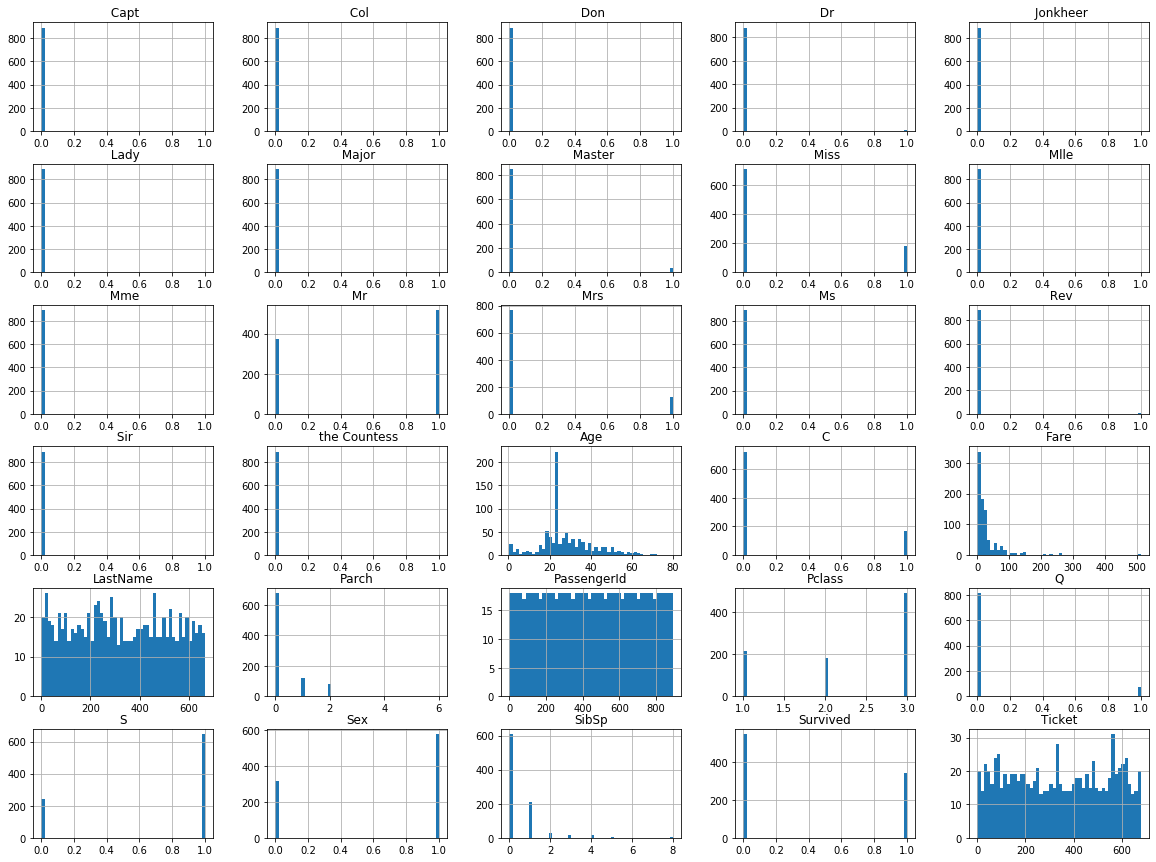

In [86]:
import matplotlib.pyplot as plt
preprocessed_titanic_data_df.hist(bins=50,figsize=(20,15))
plt.show()

* Note: The ranges for these features vary pretty heavily (Age : [0,80] , PassengerId : [0,800]). We can obviously benefit from some form of **feature scaling**.

## Discover Correlations

In [87]:
corr_matrix = preprocessed_titanic_data_df.corr()

In [88]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived         1.000000
 Mrs             0.339040
 Miss            0.327093
Fare             0.257307
C                0.168240
 Master          0.085221
Parch            0.081629
 Mlle            0.060095
 Mme             0.042470
 Ms              0.042470
 Lady            0.042470
 Sir             0.042470
 the Countess    0.042470
 Major           0.011329
 Col             0.011329
 Dr              0.008185
Q                0.003650
PassengerId     -0.005007
 Don            -0.026456
 Capt           -0.026456
 Jonkheer       -0.026456
SibSp           -0.035322
Age             -0.052872
LastName        -0.058100
 Rev            -0.064988
S               -0.149683
Ticket          -0.164549
Pclass          -0.338481
Sex             -0.543351
 Mr             -0.549199
Name: Survived, dtype: float64